# setting up imports

In [1]:
# Install a compatible version of TensorFlow, e.g., 2.8 or higher

!pip install tensorflow==2.8.0



# Install the other required packages

!pip install mne>=0.17.1 PyRiemann>=0.2.5 scikit-learn>=0.20.1 matplotlib>=2.2.3


In [2]:
# Clone the repository (replace the URL with the correct one if needed)

!git clone https://github.com/vlawhern/arl-eegmodels.git



# Navigate to the cloned directory

%cd arl-eegmodels


fatal: destination path 'arl-eegmodels' already exists and is not an empty directory.
/kaggle/working/arl-eegmodels


In [3]:
eeg = "/kaggle/input/beta-dataset/BETA"

# Data Loading



For the EEGModels project, the expected input data type is EEG (Electroencephalography) signal data, typically represented as a 3D array with the following structure:



1. **Samples/Trials (N):** The number of individual EEG recordings or trials in the dataset. Each sample represents an independent recording or a segment of an EEG signal.

2. **Channels (Chans):** The number of EEG electrodes or channels used in the recordings. Common EEG systems use configurations with 32, 64, or 128 channels, representing different scalp locations where EEG signals are measured.

3. **Time Points/Samples (Samples):** The number of time points or samples per EEG channel. It represents the length of the EEG recording in terms of discrete time steps. For example, if the EEG signal was recorded for 1 second at a sampling rate of 128 Hz, the number of time points would be 128.



### Expected Shape of the Data

The input data should have the shape `(N, Chans, Samples)`, where:

- `N` is the number of samples (trials or recordings),

- `Chans` is the number of EEG channels,

- `Samples` is the number of time points in each recording.



### Example Data Shape

- **Shape:** `(100, 64, 128)`

  - **100 samples:** There are 100 individual trials/recordings.

  - **64 channels:** The EEG system uses 64 electrodes.

  - **128 time points:** Each trial is 1 second long at a sampling rate of 128 Hz.



### Labels for Classification

The expected output labels for classification tasks are typically categorical labels representing different classes. For binary classification (e.g., detecting a specific mental state), you might use `0` and `1` as class labels. For multiclass problems, the labels can be integers representing different categories (e.g., different cognitive tasks or conditions).



### Data Preprocessing

- **Normalization:** EEG data often needs to be normalized, typically channel-wise.

- **Reshaping:** Ensure the data is in the correct format `(N, Chans, Samples)`.

- **One-Hot Encoding:** Convert labels to one-hot encoding if using categorical cross-entropy loss.



If the data is not already segmented, you may need to preprocess it into smaller chunks (trials) for training the models.

# VISUALIZING A SINGLE DATASET 

EEG Data Type: <class 'numpy.ndarray'>
EEG Data Shape: (64, 1000, 4, 40)


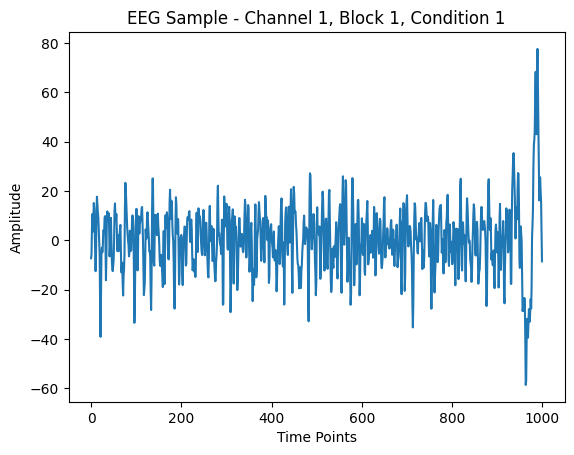

In [4]:
import scipy.io

# Load the .mat file
# file_path = '/kaggle/input/beta-dataset/BETA/S10.mat'
file_path = '/kaggle/input/beta-dataset/BETA/S27.mat'
mat_data = scipy.io.loadmat(file_path)

# Access the inner data
# Start with the main 'data' key, then index down to the actual EEG values
eeg_data = mat_data['data'][0, 0][0]  # Adjust indices based on structure

# Check the shape and type to confirm
print("EEG Data Type:", type(eeg_data))
print("EEG Data Shape:", eeg_data.shape)

import matplotlib.pyplot as plt

# Assuming the data has the shape: [channels, time points, blocks, conditions]
# Select the first channel, first block, first condition for a quick visualization

if eeg_data.ndim >= 3:
    time_series_sample = eeg_data[0, :, 0, 0]  # Adjust indices if necessary

    # Plot the sample time series
    plt.plot(time_series_sample)
    plt.title("EEG Sample - Channel 1, Block 1, Condition 1")
    plt.xlabel("Time Points")
    plt.ylabel("Amplitude")
    plt.show()
else:
    print("Data structure appears different; check contents for further inspection.")


# PRE-PROCESSING

In [5]:
import os

import numpy as np

from scipy.io import loadmat

from scipy.signal import cheby1, filtfilt, resample

from tensorflow.keras.utils import to_categorical



def chebyshev_bandpass(lowcut, highcut, fs, order=4, rp=0.5):

    """

    Design a Chebyshev Type I bandpass filter.



    Parameters:

    - lowcut: Low frequency cut-off for the bandpass filter.

    - highcut: High frequency cut-off for the bandpass filter.

    - fs: Sampling frequency of the EEG data.

    - order: The order of the filter (default: 4).

    - rp: Maximum ripple in the passband (default: 0.5 dB).



    Returns:

    - b, a: Numerator (b) and denominator (a) polynomials of the filter.

    """

    nyquist = 0.5 * fs

    low = lowcut / nyquist

    high = highcut / nyquist

    b, a = cheby1(order, rp, [low, high], btype='band')

    return b, a



def load_eeg_data(eeg, n_channels=64, n_timepoints=1500, n_classes=40,

                  lowcut=6.0, highcut=90.0, fs=1000, target_fs=250,

                  window_length=250):

    """

    Load EEG data from .mat files in a directory, apply Chebyshev bandpass filter,

    downsample, segment with sliding window, and return as arrays.



    Parameters:

    - data_dir: Directory containing .mat files.

    - n_channels: Number of EEG channels (default: 64).

    - n_timepoints: Number of time points per trial (default: 1500).

    - n_classes: Number of target classes (default: 40).

    - lowcut: Low frequency cut-off for Chebyshev bandpass filter (default: 6 Hz).

    - highcut: High frequency cut-off for Chebyshev bandpass filter (default: 90 Hz).

    - fs: Original sampling frequency of the EEG data (default: 1000 Hz).

    - target_fs: Target sampling frequency after downsampling (default: 250 Hz).

    - window_length: Length of each segment window in samples (default: 250 samples for 1s at 250 Hz).



    Returns:

    - X: EEG data as a NumPy array with shape (N, Chans, Samples).

    - y: One-hot encoded labels as a NumPy array.

    """

    X, y = [], []

    b, a = chebyshev_bandpass(lowcut, highcut, fs, order=4)  # Define Chebyshev filter
    


    # Iterate through each .mat file in the directory

    for file_name in os.listdir(eeg):

        if file_name.endswith('.mat'):

            file_path = os.path.join(eeg, file_name)

            mat_data = loadmat(file_path)



            # Assuming data is stored in 'data' variable with shape [64, 1500, 40, 6]

            # ipdb.set_trace()
            eeg_data = mat_data['data'][0, 0][0] 



            # Process each trial

            for target_idx in range(eeg_data.shape[2]):

                for block_idx in range(eeg_data.shape[3]):

                    trial_data = eeg_data[:, :, target_idx, block_idx]  # Shape: [64, 1500]
        

                    # Apply bandpass filter

                    trial_data_filtered = np.zeros_like(trial_data)

                    for ch in range(n_channels):

                        trial_data_filtered[ch, :] = filtfilt(b, a, trial_data[ch, :])



                    # Downsample to target sampling rate

                    trial_data_downsampled = resample(trial_data_filtered, int(trial_data_filtered.shape[1] * target_fs / fs), axis=1)



                    # Apply sliding window to generate segments

                    for start in range(0, trial_data_downsampled.shape[1] - window_length + 1, window_length):

                        segment = trial_data_downsampled[:, start:start + window_length]



                        # Normalize segment channel-wise

                        segment = (segment - segment.mean(axis=1, keepdims=True)) / segment.std(axis=1, keepdims=True)



                        # Append the segment and label

                        X.append(segment)

                        y.append(target_idx)  # Label as the target index



    # Convert lists to NumPy arrays

    X = np.array(X)  # Shape: [num_samples, 64, window_length]

    y = np.array(y)  # Shape: [num_samples]



    # Convert labels to one-hot encoding

    y = to_categorical(y, num_classes=n_classes)

    print(X.shape)

    print(y.shape)

    return X, y




In [6]:
import torch

torch.cuda.empty_cache()

import gc

gc.collect()



# Load and preprocess data

# data_dir = '/content/drive/MyDrive/11785-IDL-Project-Team19/data'
print(eeg)
X, y = load_eeg_data(eeg)



# Split into training and validation sets

#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess EEG Data

/kaggle/input/beta-dataset/BETA
(8800, 64, 250)
(8800, 40)


# MODEL ARCHITECTURE

parametes passed into the EEGNet includes:





1.   **nb_classes**: The number of output classes for classification

2.   **Chans**: The number of EEG channels in your data (i.e., the number of electrodes).This parameter should match the second dimension of your input data shape.

3.   **Samples**: The number of time points per trial. This corresponds to the number of time samples in each EEG segment.



optional parameters include:





1.   **dropoutRate**: The dropout rate for regularization (default is 0.5).

2.   **kernLength**: The length of the convolution kernel (default is 64).

3.   **F1**: Number of temporal filters (default is 8).

4.   **D**: Depth multiplier for the separable convolution (default is 2).

5.     **F2**: Number of spatial filters (default is F1 * D).

6.   **norm_rate**: The dropout fraction for the normalization layer (default is 0.25).
















In [7]:
from EEGModels import EEGNet, ShallowConvNet, DeepConvNet



# Creating an EEGNet model : params include:

model = EEGNet(nb_classes=40, Chans=64, Samples=1500, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout')



# Compile the model

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 1500, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 1500, 8)       512       
                                                                 
 batch_normalization (BatchN  (None, 64, 1500, 8)      32        
 ormalization)                                                   
                                                                 
 depthwise_conv2d (Depthwise  (None, 1, 1500, 16)      1024      
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 1, 1500, 16)      64        
 hNormalization)                                                 
                                                             

# TRAINING THE MODEL



We use keras framework - so we are going to train using model.fit()





1.   **X_train** = This parameter represents the input training data. It should be a NumPy array or a tensor, with dimensions that match the input shape expected by the model.

2.   **Y_train** = This is the target output (labels) corresponding to the input data X_train. It should be a NumPy array of labels, either one-hot encoded (for categorical classification) or as class integers

3.   **batch_size** = This defines the number of training samples to process before updating the model's weights.

4.  **epochs** = This indicates the number of complete passes through the entire training dataset



5.  **verbose** = This controls the output displayed during training:



*   0: No output (silent mode).

*   1: Displays a progress bar for each epoch.

*   2: Displays one line per epoch with the loss and accuracy.



Using verbose=2 provides a compact summary for each epoch, showing the training metrics without the progress bar.




In [ ]:
from sklearn.model_selection import KFold

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import l2

from tensorflow.keras.initializers import RandomNormal





# Initialize KFold with 10 splits

kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize lists to store validation scores for each fold

val_losses = []

val_accuracies = []

initializer = RandomNormal(mean=0.0, stddev=0.1)

# Loop through each fold

for fold, (train_index, val_index) in enumerate(kf.split(X)):

    print(f"Training fold {fold + 1}...")



    # Split data into training and validation sets for this fold

    X_train, X_val = X[train_index], X[val_index]

    y_train, y_val = y[train_index], y[val_index]



    # Clear previous model weights (to ensure training from scratch for each fold)

   # Creating an EEGNet model : params include:

    model = EEGNet(nb_classes=40, Chans=64, Samples=250, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, dropoutType='Dropout')



    # Compile the model

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])



    history = model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1,

                        validation_data=(X_val, y_val))



    # Get the final validation loss and accuracy for this fold

    loss = history.history['val_loss'][-1]

    accuracy = history.history['val_accuracy'][-1]





    # Store the results

    val_losses.append(loss)

    val_accuracies.append(accuracy)



    print(f"Fold {fold + 1} - Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")



# Calculate average performance across all folds

avg_loss = np.mean(val_losses)

avg_accuracy = np.mean(val_accuracies)



print(f"\n10-Fold Cross-Validation Results:")

print(f"Average Validation Loss: {avg_loss:.4f}")

print(f"Average Validation Accuracy: {avg_accuracy:.4f}")

Training fold 1...
Epoch 1/50
248/248 [==============================] - 82s 326ms/step - loss: 2.2572 - accuracy: 0.2479 - val_loss: 2.3618 - val_accuracy: 0.2489
Epoch 2/50
248/248 [==============================] - 81s 326ms/step - loss: 1.5382 - accuracy: 0.2460 - val_loss: 1.4964 - val_accuracy: 0.2648
Epoch 3/50
248/248 [==============================] - 80s 322ms/step - loss: 1.4679 - accuracy: 0.2460 - val_loss: 1.4213 - val_accuracy: 0.2545
Epoch 4/50
248/248 [==============================] - 80s 325ms/step - loss: 1.4477 - accuracy: 0.2553 - val_loss: 1.4085 - val_accuracy: 0.2341
Epoch 5/50
248/248 [==============================] - 80s 322ms/step - loss: 1.4384 - accuracy: 0.2499 - val_loss: 1.4084 - val_accuracy: 0.2466
Epoch 6/50
248/248 [==============================] - 84s 340ms/step - loss: 1.4292 - accuracy: 0.2446 - val_loss: 1.4016 - val_accuracy: 0.2625
Epoch 7/50
248/248 [==============================] - 80s 323ms/step - loss: 1.4219 - accuracy: 0.2525 - val_lo

In [ ]:
model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=2)

# EVALUATING THE MODEL



The .evaluate() method is used to assess the model’s performance on a validation or test dataset. It returns the loss value and any specified metrics (like accuracy) for the dataset.




In [ ]:
loss, accuracy = model.evaluate(X_val, y_val, batch_size=32, verbose=2)

print(f"Validation Loss: {loss}")

print(f"Validation Accuracy: {accuracy}")


alternatively, we can pass validation data during the model training (it helps regulate overfitting)



The model will evaluate its performance on X_val and y_val after each epoch, and the loss and accuracy will be reported.



This helps track how the model's performance on unseen data evolves over time, which is useful for detecting overfitting early.



Additionally, we can use callbacks like EarlyStopping to stop training if the validation loss does not improve for a specified number of epochs.

In [ ]:
#model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=2, validation_data=(X_val, y_val))


How to use callbacks at model.fit() - [tensorflow.keras.callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping



# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



# model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=2, validation_data=(X_val, y_val), callbacks=[early_stopping])
